## Recursive NN vs Recurrent NN

Recurrent Neural Networks (RNN) basically unfolds over time. It is used for sequential inputs where the time factor is the main differentiating factor between the elements of the sequence. For example, here is a recurrent neural network used for language modeling that has been unfolded over time. At each time step, in addition to the user input at that time step, it also accepts the output of the hidden layer that was computed at the previous time step.  

For example if you have a sequence  
x = ['h', 'e', 'l', 'l']

This sequence is fed to a single neuron which has a single connection to itself.  
At time step 0, the letter 'h' is given as input.At time step 1, 'e' is given as input. The network when unfolded over time will look like this.
$$$$

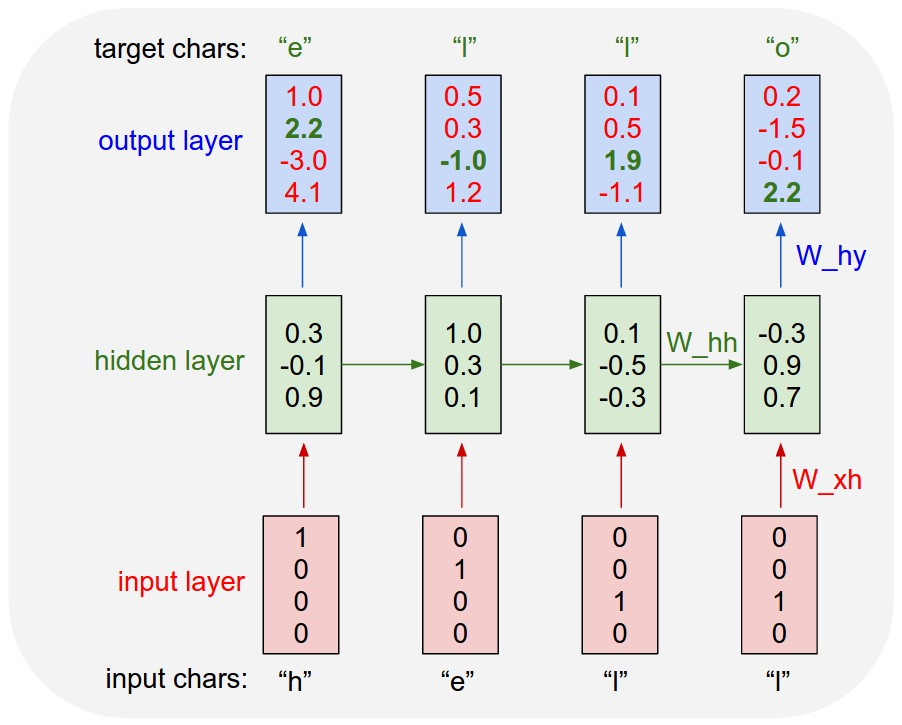  

                                                            Recurrent NN
$$$$

A Recursive Neural Networks is more like a hierarchical network where there is really no time aspect to the input sequence but the input has to be processed hierarchically in a tree fashion. Here is an example of how a recursive neural network looks. It shows the way to learn a parse tree of a sentence by recursively taking the output of the operation performed on a smaller chunk of the text.

A recursive network is just a generalization of a recurrent network. In a recurrent network the weights are shared (and dimensionality remains constant) along the length of the sequence because how would you deal with position-dependent weights when you encounter a sequence at test-time of different length to any you saw at train-time. In a recursive network the weights are shared (and dimensionality remains constant) at every node for the same reason.

This means that all the W_xh weights will be equal(shared) and so will be the W_hh weight. This is simply because it is a single neuron which has been unfolded in time.

This is what a Recursive Neural Network looks like. 


![](https://i.stack.imgur.com/ngG5S.png)
                                           
                                                            Recursive NN

The weights in each branch node are tied with each other, and the weights in each leaf node are tied with each other. Usually, we just restrict the Recursive NN to be a binary tree – each node either has one or two input nodes. There may be different types of branch nodes, but branch nodes of the same type have tied weights.

The advantage of Recursive NN is that they can be very powerful in learning hierarchical, tree-like structure. 

The disadvantages are, firstly, that the tree structure of every input sample must be known at training time. The second disadvantage of TreeNets is that training is hard because the tree structure changes for each training sample and it’s not easy to map training to mini-batches and so on.

### Basic Architecture

<img src="https://upload.wikimedia.org/wikipedia/commons/6/60/Simple_recursive_neural_network.svg" style="height: 300px;" />  

$$$$

A recursive neural network is a kind of deep neural network created by applying the same set of weights recursively over a structured input, to produce a structured prediction over variable-size input structures, or a scalar prediction on it, by traversing a given structure in topological order.

In the most simple architecture, nodes are combined into parents using a weight matrix that is shared across the whole network, and a non-linearity such as tanh. If c1 and c2 are n-dimensional vector representation of nodes, their parent will also be an n-dimensional vector, calculated as $ p_{1,2}=\tanh \left(W[c_{1};c_{2}]\right)$ 
 
Where W is a learned $ n\times 2n$ 
 weight matrix. 
This architecture, with a few improvements, has been used for successfully parsing natural scenes and for syntactic parsing of natural language sentences.

### Implementation

There are a few methods for training Recursive NNs. The method we’re going to be using is a method that is probably the simplest, conceptually. It consists of simply assigning a tensor to every single intermediate form. So, for instance, we would like to find out the parity (odd or even-ness) of various numbers, and our input expressions are the following (in lisp-like notation):

So 1 would have parity 1, 2 = (+ 1 1) (which is equal to 2) would have parity 0, 5 = (+ 1 (* (+ 1 1) (+ 1 1))) (which is equal to 5) would have parity 1, and so on. LISP-like notation can be easily understood with the following diagram
$$$$

<img src="https://ocaml.org/img/lisp-like-tree.png" style="height: 200px;" />

Now our full list of intermediate forms is:

We can see that all of our intermediate forms are simple expressions of other intermediate forms (or inputs). Each of these corresponds to a separate sub-graph in our tensorflow graph. So, for instance, for *, we would have two matrices W_times_l and W_times_r, and one bias vector bias_times. And for computing d, we would have:

Similarly, for computing e we would have:

The full intermediate graph (excluding input and loss calculation) looks like:

For training, we simply initialize our inputs and outputs as one-hot vectors, 1 as [0 1] and 0 as [1 0] and perform gradient descent over all W and bias matrices in our graph. The advantage of this method is that, it’s straightforward and easy to implement. The disadvantage is that our graph complexity grows as a function of the input size. 

The complete code using tensorflow is as below

In [3]:
import types

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np


# Expressions are represented as lists of lists,
# in lisp style -- the symbol name is the head (first element)
# of the list, and the arguments follow.
# add an expression to an expression list, recursively if necessary.

def add_expr_to_list(exprlist, expr):
	# if expr is a atomic type
	if isinstance(expr, list):
		# Now for rest of expression
		for e in expr[1:]:
			# Add to list if necessary
			if not (e in exprlist):
				add_expr_to_list(exprlist, e)

	# Add index in list.
	exprlist.append(expr)

def expand_subexprs(exprlist):
	new_exprlist = []
	orig_indices = []
	for e in exprlist:
		add_expr_to_list(new_exprlist, e)
		orig_indices.append(len(new_exprlist)-1)
	return new_exprlist, orig_indices

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
def compile_expr(exprlist, expr):
	# start new list starting with head
	new_expr = [expr[0]]
	for e in expr[1:]:
		new_expr.append(exprlist.index(e))
	return new_expr

def compile_expr_list(exprlist):
	new_exprlist = []
	for e in exprlist:
		if isinstance(e, list):
			new_expr = compile_expr(exprlist, e)
		else:
			new_expr = e
		new_exprlist.append(new_expr)
	return new_exprlist

def expand_and_compile(exprlist):
	l, orig_indices = expand_subexprs(exprlist)
	return compile_expr_list(l), orig_indices

In [8]:
def new_weight(N1,N2):
    return tf.Variable(tf.random.normal([N1,N2]))

def new_bias(N_hidden):
    return tf.Variable(tf.random.normal([N_hidden]))

def build_weights(exprlist,N_hidden,inp_vec_len,out_vec_len):
	W = dict()  # dict of weights corresponding to each operation
	b = dict()  # dict of biases corresponding to each operation
	W['input']  = new_weight(inp_vec_len, N_hidden)
	W['output'] = new_weight(N_hidden, out_vec_len)
	for expr in exprlist:
		if isinstance(expr, list):
			idx = expr[0]
			if not (idx in W):
				W[idx] = [new_weight(N_hidden,N_hidden) for i in expr[1:]]
				b[idx] = new_bias(N_hidden)
	return (W,b)

In [9]:
def build_rnn_graph(exprlist,W,b,inp_vec_len):
	# with W built up, create list of variables
	# intermediate variables
	in_vars = [e for e in exprlist if not isinstance(e,list)]
	N_input = len(in_vars)
	inp_tensor = tf.placeholder(tf.float32, (N_input,  inp_vec_len), name='input1')
	V = []      # list of variables corresponding to each expr in exprlist
	for expr in exprlist:
		if isinstance(expr, list):
			# intermediate variables
			idx = expr[0]
			# add bias
			new_var = b[idx]
			# add input variables * weights
			for i in range(1,len(expr)):
				new_var = tf.add(new_var, tf.matmul(V[expr[i]], W[idx][i-1]))
			new_var = tf.nn.relu(new_var)
		else:
			# base (input) variables
			# TODO : variable or placeholder?
			i = in_vars.index(expr)
			i_v = tf.slice(inp_tensor, [i,0], [1,-1])
			new_var = tf.nn.relu(tf.matmul(i_v,W['input']))
		V.append(new_var)
	return (inp_tensor,V)

In [10]:
# take a compiled expression list and build its RNN graph
def complete_rnn_graph(W,V,orig_indices,out_vec_len):
	# we store our matrices in a dict;
	# the dict format is as follows:
	# 'op':[mat_arg1,mat_arg2,...]
	# e.g. unary operations:  '-':[mat_arg1]
	#      binary operations: '+':[mat_arg1,mat_arg2]
	# create a list of our base variables
	N_output = len(orig_indices)
	out_tensor = tf.placeholder(tf.float32, (N_output, out_vec_len), name='output1')
	# output variables
	ce = tf.reduce_sum(tf.zeros((1,1)))
	for idx in orig_indices:
		o = tf.nn.softmax(tf.matmul(V[idx], W['output']))
		t = tf.slice(out_tensor, [idx,0], [1,-1])
		ce = tf.add(ce, -tf.reduce_sum(t * tf.log(o)), name='loss')
	# TODO: output variables
	# return weights and variables and final loss
	return (out_tensor, ce)

In [12]:
# from subexpr_lists import *
a = [ 1, ['+',1,1], ['*',1,1], ['*',['+',1,1],['+',1,1]], ['+',['+',1,1],['+',1,1]], ['+',['+',1,1],1 ], ['+',1,['+',1,1]]]
# generate training graph
l,o=expand_and_compile(a)
W,b = build_weights(l,10,1,2)
i_t,V = build_rnn_graph(l,W,b,1)
o_t,ce = complete_rnn_graph(W,V,o,2)

# generate testing graph
a = [ ['+',['+',['+',1,1],['+',['+',1,1],['+',1,1]]],1] ]  # 7
l_tst,o_tst=expand_and_compile(a)
i_t_tst,V_tst = build_rnn_graph(l_tst,W,b,1)

out_batch = np.transpose(np.array([[1,0,1,0,0,1,1],[0,1,0,1,1,0,0]]))
print(ce)

train_step = tf.train.GradientDescentOptimizer(0.001).minimize(ce)
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

for i in range(5000):
	sess.run(train_step, feed_dict={i_t:np.array([[1]]),o_t:out_batch})
print(l)
print(l_tst)
print(sess.run(tf.nn.softmax(tf.matmul(V[1], W['output'])), feed_dict={i_t:np.array([[1]])}))
print(sess.run(tf.nn.softmax(tf.matmul(V[-1], W['output'])), feed_dict={i_t:np.array([[1]])}))
print(sess.run(tf.nn.softmax(tf.matmul(V_tst[-2], W['output'])), feed_dict={i_t_tst:np.array([[1]])}))
print(sess.run(tf.nn.softmax(tf.matmul(V_tst[-1], W['output'])), feed_dict={i_t_tst:np.array([[1]])}))

Tensor("loss_13:0", shape=(), dtype=float32)
[1, ['+', 0, 0], ['*', 0, 0], ['*', 1, 1], ['+', 1, 1], ['+', 1, 0], ['+', 0, 1]]
[1, ['+', 0, 0], ['+', 1, 1], ['+', 1, 2], ['+', 3, 0]]
[[3.7394583e-04 9.9962604e-01]]
[[9.9976283e-01 2.3719975e-04]]
[[1. 0.]]
[[0. 1.]]
